# 딥러닝 활용 연습

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
input_size = 28 * 28
hidden_size = 512
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# 데이터셋 다운로드

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# 빠른 실험을 위해 데이터셋의 일부만 사용 (train set에서 10%만 사용)
train_data, _ = torch.utils.data.random_split(train_data, [6000, 54000])

In [7]:
# validation set 분리
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [8]:
len(train_data), len(val_data), len(test_data)

(4800, 1200, 10000)

In [9]:
# Train, Validation, Test DataLoader 생성
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
# define simple FNN
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [11]:
model = FNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

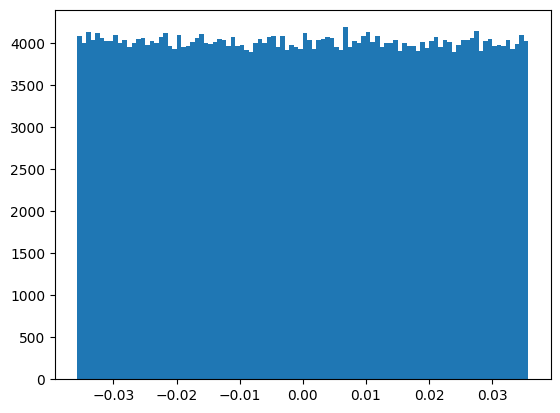

In [12]:
w1 = model.fc1.weight.detach().numpy().flatten()
plt.hist(w1, bins=100)
plt.show()
# Pytorch Linear layer's default initialization: He (Kaiming) uniform initialization

# 딥러닝의 Hyperparameters

## Modifying the network (weight initialization, activation function)

In [13]:
# modify FNN with weight initialization (Xavier (uniform)) and activation function (Tanh)

class FNN_Xavier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN_Xavier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.flatten = nn.Flatten()

        ########################################################
        # weight initialization (Kaiming normal)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        ########################################################

    def forward(self, x):
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        return out

In [14]:
model = FNN_Xavier(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

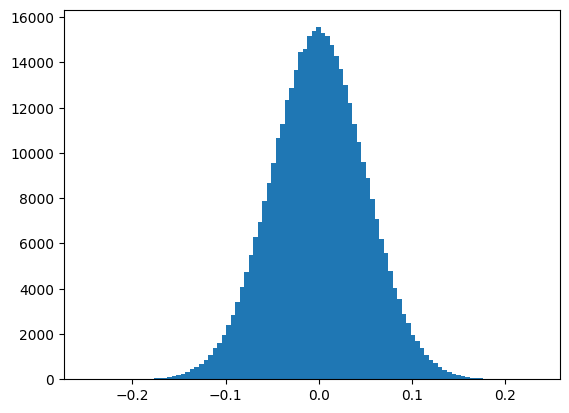

In [15]:
# get linear layer's weights
w1 = model.fc1.weight.detach().numpy().flatten()
plt.hist(w1, bins=100)
plt.show()

## Optimizer

- 다양한 optimizer를 사용하여 학습 속도를 비교해보자.

In [16]:
# SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# RMSprop
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Loss Function

- Task에 따라 다른 loss function을 사용해보자.

In [17]:
# Classification Loss

## Cross Entropy Loss (Multi-class classification)
loss_fn = nn.CrossEntropyLoss()

## Binary Cross Entropy Loss (Binary classification)
loss_fn = nn.BCELoss()


# Regression Loss

## Mean Squared Error Loss
loss_fn = nn.MSELoss()

## Mean Absolute Error Loss
loss_fn = nn.L1Loss() # not recommended for regression because of its non-convexity


# Regularization

## Learning curve

- Learning Curve를 통해 overfitting을 확인해보자.

- 우선 앞서 배운 Train Loop와 Validation Loop를 함수화하여 사용해보자.

In [18]:
#######################################################
# Train Loop
def train_loop(dataloader, model, loss_fn, optimizer, device):
    # 모델을 train 모드로 설정
    model.train()
    # 초기 loss 값을 0으로 설정
    total_loss = 0
    for X, y in dataloader:
        # Forward pass
        pred = model(X.to(device))
        # Loss 계산
        loss = loss_fn(pred, y.to(device))

        # Reset gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()

        # Loss 값 누적
        total_loss += loss.item()
    # 평균 loss 값 계산
    train_loss = total_loss / len(dataloader)

    # 평균 loss 값 반환
    return train_loss
#######################################################


In [19]:
def test_loop(dataloader, model, loss_fn, device):
    # 초기 loss 값과 정답 개수를 0으로 설정
    total_loss, correct = 0, 0
    model.eval() # 모델을 evaluation 모드로 설정
    with torch.no_grad(): # Gradient 계산을 하지 않음
        for X, y in dataloader:
            # Forward pass
            pred = model(X.to(device))
            # Loss 계산
            total_loss += loss_fn(pred, y.to(device)).item()
            # 정답 개수 계산
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    # 평균 loss 값 계산
    test_loss = total_loss / len(dataloader)
    # 정확도 계산
    correct /= len(dataloader.dataset)
    return test_loss, correct

In [20]:
# Training

# 모델 정의
model = FNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

# Optimizer, Loss function 정의 (Optimizer: Adam, Loss function: Cross Entropy Loss)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
# Learning Curve를 그리기 위한 로그 리스트
train_log = []
val_log = []
for t in range(epochs):
    # Train Loop
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    # Validation Loop
    val_loss, val_acc = test_loop(val_dataloader, model, loss_fn, device)
    # 로그 출력
    if t % 5 == 0:
        print(f"Epoch: {t:2d}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")
    # 로그 리스트에 저장 (Training loss, Validation loss)
    train_log.append(train_loss)
    val_log.append(val_loss)
print("Done!")

Epoch:  0, Train loss: 0.7849, Validation loss: 0.3668, Validation accuracy: 0.8925
Epoch:  5, Train loss: 0.1137, Validation loss: 0.2137, Validation accuracy: 0.9358
Epoch: 10, Train loss: 0.0324, Validation loss: 0.1876, Validation accuracy: 0.9467
Epoch: 15, Train loss: 0.0093, Validation loss: 0.1907, Validation accuracy: 0.9458
Epoch: 20, Train loss: 0.0043, Validation loss: 0.1987, Validation accuracy: 0.9442
Epoch: 25, Train loss: 0.0025, Validation loss: 0.1996, Validation accuracy: 0.9425
Epoch: 30, Train loss: 0.0016, Validation loss: 0.2076, Validation accuracy: 0.9425
Epoch: 35, Train loss: 0.0011, Validation loss: 0.2110, Validation accuracy: 0.9442
Epoch: 40, Train loss: 0.0008, Validation loss: 0.2176, Validation accuracy: 0.9458
Epoch: 45, Train loss: 0.0006, Validation loss: 0.2230, Validation accuracy: 0.9450
Done!


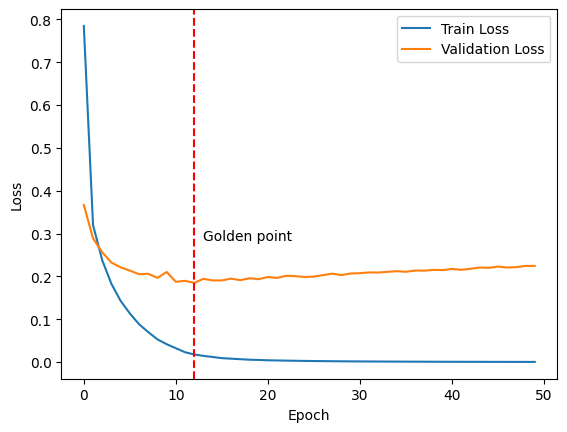

In [22]:
# Learning Curve
# plot train and validation loss
plt.plot(train_log, label='Train Loss')
plt.plot(val_log, label='Validation Loss')

# vertical line for lowest validation loss
plt.axvline(x=np.argmin(val_log), color='r', linestyle='--')
plt.text(np.argmin(val_log)+1, np.min(val_log)+0.1, 'Golden point', color='k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 오버피팅에 의한 성능 저하
# 학습 시간 낭비

In [23]:
# Prediction Function

def predict(model, test_loader, device):
    model.eval()
    pred_list = []
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x.to(device))
            pred_list.append(pred.cpu().softmax(1).numpy())
    return np.concatenate(pred_list)

In [24]:
# Test set에 대한 예측
y_test_pred = predict(model, test_dataloader, device)

In [25]:
# y_test_pred shape 확인
print(y_test_pred.shape)

(10000, 10)


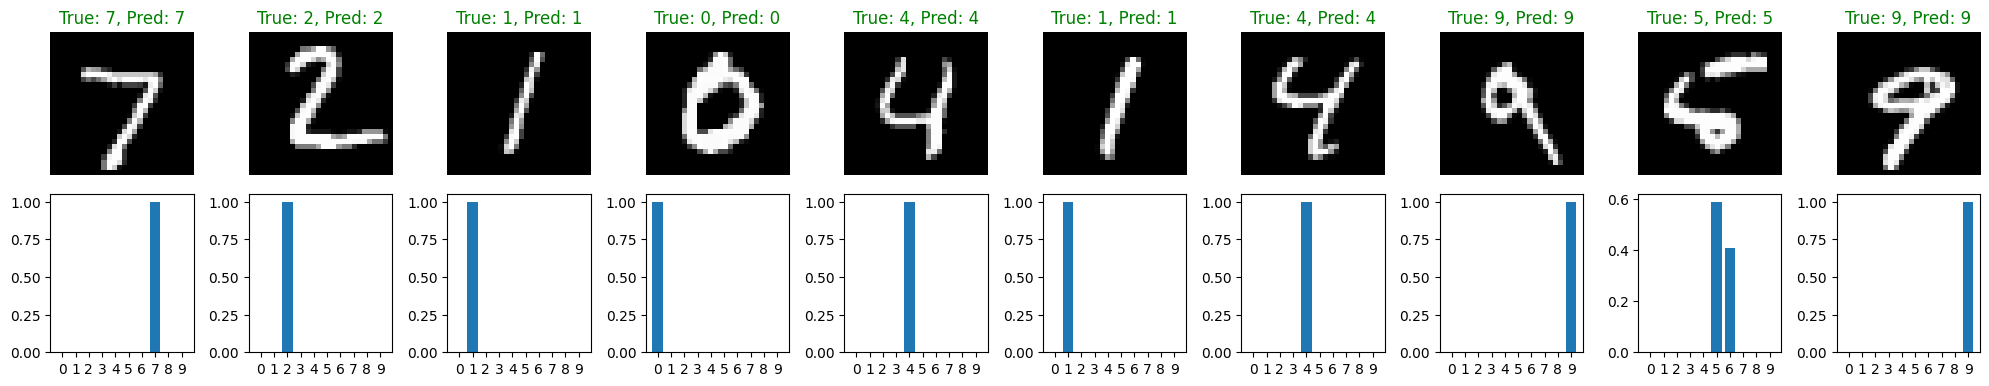

In [26]:
# display the first 10 predictions with images
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
ax = ax.flatten()
for i in range(10):
    # plot the image (first row)
    ax[i].imshow(test_data[i][0].reshape(28, 28), cmap='gray') 
    ax[i].axis('off')
    color = 'green' if np.argmax(y_test_pred[i]) == test_data[i][1] else 'red'
    ax[i].set_title(f"True: {test_data[i][1]}, Pred: {np.argmax(y_test_pred[i])}", color=color)

    # plot the probability distribution (second row)
    ax[i+10].bar(np.arange(10), y_test_pred[i]) 
    ax[i+10].set_xticks(np.arange(10)) 
plt.tight_layout()
plt.show()

## Early Stopping

In [28]:
# 모델 정의
model = FNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

# Optimizer, Loss function 정의 (Optimizer: Adam, Loss function: Cross Entropy Loss)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# max epochs: 50
epochs = 50
# Learning Curve를 그리기 위한 로그 리스트 (Training loss, Validation loss)
train_log = []
val_log = []

# Training
## 종료 조건 - 1: max epochs에 도달하면 종료, 2: validation loss가 5번 이상 개선되지 않으면 종료
for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    val_loss, val_acc = test_loop(val_dataloader, model, loss_fn, device)
    print(f"Epoch: {t:2d}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")
    train_log.append(train_loss)
    val_log.append(val_loss)

    # Save best model (lowest validation loss)

    ########################################################
    if t == np.argmin(val_log):
        torch.save(model.state_dict(), "best_model.pt")
        # print("Saved best model (epoch {})".format(t))
    ########################################################

    ########################################################
    # Early stopping
    elif (t - np.argmin(val_log)) > 5:
        print("Early stopping")
        break
    ########################################################

print("Done!")

Epoch:  0, Train loss: 0.7912, Validation loss: 0.3664, Validation accuracy: 0.8933
Epoch:  1, Train loss: 0.3183, Validation loss: 0.2871, Validation accuracy: 0.9117
Epoch:  2, Train loss: 0.2326, Validation loss: 0.2709, Validation accuracy: 0.9225
Epoch:  3, Train loss: 0.1855, Validation loss: 0.2518, Validation accuracy: 0.9192
Epoch:  4, Train loss: 0.1397, Validation loss: 0.2156, Validation accuracy: 0.9358
Epoch:  5, Train loss: 0.1098, Validation loss: 0.2128, Validation accuracy: 0.9400
Epoch:  6, Train loss: 0.0866, Validation loss: 0.2138, Validation accuracy: 0.9367
Epoch:  7, Train loss: 0.0641, Validation loss: 0.2053, Validation accuracy: 0.9375
Epoch:  8, Train loss: 0.0491, Validation loss: 0.1990, Validation accuracy: 0.9408
Epoch:  9, Train loss: 0.0380, Validation loss: 0.1865, Validation accuracy: 0.9458
Epoch: 10, Train loss: 0.0295, Validation loss: 0.1914, Validation accuracy: 0.9442
Epoch: 11, Train loss: 0.0240, Validation loss: 0.1918, Validation accuracy:

## Learning rate scheduler

In [29]:
# reduce learning rate when validation loss plateaus
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
## mode: min or max
## factor: Multiplicative factor of learning rate decay
## patience: Number of epochs with no improvement after which learning rate will be reduced
## verbose: If True, prints a message to stdout for each update


# reduce learning rate every epoch
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
## gamma: Multiplicative factor of learning rate decay


# reduce learning rate every 10 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) 
## step_size: Period of learning rate decay
## gamma: Multiplicative factor of learning rate decay

In [30]:
model = FNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss_fn = nn.CrossEntropyLoss()

epochs = 50
train_log = []
val_log = []
for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    val_loss, val_acc = test_loop(val_dataloader, model, loss_fn, device)
    print(f"Epoch: {t:2d}, Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")
    train_log.append(train_loss)
    val_log.append(val_loss)

    # Save best model
    if t == np.argmin(val_log):
        torch.save(model.state_dict(), "best_model.pt")
        # print("Saved best model (epoch {})".format(t))

    # Early stopping
    elif (t - np.argmin(val_log)) > 5:
        print("Early stopping")
        break

    ########################################################
    # Learning rate scheduler per epoch
    lr_scheduler.step()

    # Learning rate scheduler at certain condition (validation loss)
    # lr_scheduler.step(val_loss)
    
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.7f}")
    ########################################################
    
print("Done!")

Epoch:  0, Train loss: 0.8118, Validation loss: 0.3610, Validation accuracy: 0.8908
Learning rate: 0.0009900
Epoch:  1, Train loss: 0.3267, Validation loss: 0.2878, Validation accuracy: 0.9067
Learning rate: 0.0009801
Epoch:  2, Train loss: 0.2455, Validation loss: 0.2766, Validation accuracy: 0.9167
Learning rate: 0.0009703
Epoch:  3, Train loss: 0.1947, Validation loss: 0.2321, Validation accuracy: 0.9350
Learning rate: 0.0009606
Epoch:  4, Train loss: 0.1496, Validation loss: 0.2231, Validation accuracy: 0.9325
Learning rate: 0.0009510
Epoch:  5, Train loss: 0.1164, Validation loss: 0.2076, Validation accuracy: 0.9408
Learning rate: 0.0009415
Epoch:  6, Train loss: 0.0924, Validation loss: 0.2064, Validation accuracy: 0.9408
Learning rate: 0.0009321
Epoch:  7, Train loss: 0.0741, Validation loss: 0.1998, Validation accuracy: 0.9433
Learning rate: 0.0009227
Epoch:  8, Train loss: 0.0605, Validation loss: 0.2104, Validation accuracy: 0.9317
Learning rate: 0.0009135
Epoch:  9, Train lo

## Weight Decay

* weight의 제곱합을 페널티 텀으로 추가  (Loss = Loss + weight_decay_factor * ||weight||^2)
* 특정 weight가 커지는 것을 방지하여 overfitting을 완화

In [31]:
# optimizer에 L2 regularization 적용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
## weight_decay: L2 regularization coefficient

## Batch Normalization

- 배치 별로 평균과 분산을 조정하여 학습을 안정적이고 빠르게 진행

In [32]:
# modify FNN with batch normalization

#
class FNN_BN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN_BN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        ########################################################
        # Batch normalization layer 추가
        self.bn1 = nn.BatchNorm1d(hidden_size)
        ########################################################
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        out = self.fc1(x)
        ########################################################
        # Batch normalization 적용
        out = self.bn1(out)
        ########################################################
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [33]:
model = FNN_BN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

## Dropout

- 노드와의 연결을 랜덤하게 끄는 방식으로 overfitting을 방지 (특정 노드에 의존하지 않도록 함)

In [35]:
# modify FNN with dropout
class FNN_Dropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.flatten = nn.Flatten()

        ########################################
        # Dropout layer 추가
        self.dropout = nn.Dropout(p=0.5)
        ########################################

    def forward(self, x):
        x = self.flatten(x)
        out = self.fc1(x)
        out = self.relu(out)
        ########################################
        # Dropout 추가
        out = self.dropout(out)
        ########################################
        out = self.fc2(out)
        return out

In [36]:
model = FNN_Dropout(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

## Transfer Learning

### Load pretrained model

In [37]:
### load pre-trained model (VGG16)

from torchvision import models

# model = models.vgg16_bn(pretrained=True)
model = models.vgg16_bn(weights="IMAGENET1K_V1")
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/develup4/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [38]:
# modify the last layer of the model to fit the number of classes
model.classifier[6] = nn.Linear(4096, num_classes)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Freeze layers

In [39]:
# freeze all layers if not last layer

for name, param in model.named_parameters():
    if name not in ["classifier.6.weight", "classifier.6.bias"]:
        param.requires_grad = False


In [40]:
# freeze layers if "features" in name

for name, param in model.named_parameters():
    if "features" in name:
        param.requires_grad = False